<a href="https://colab.research.google.com/github/wanlichen2024/Big-Data-Analytics/blob/main/ML_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [ ]:
# initiate SparkSession
spark = SparkSession.builder.appName("Time Series Prediction").getOrCreate()

# loading data
data_path = "/content/drive/MyDrive/cleaned_data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# confirm columns name
print(df.columns)

['TIMESTAMP', 'period_hour', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday']


In [ ]:
# feature selection
df = df.select("timestamp", "nd", "tsd", "embedded_wind_capacity","embedded_solar_capacity")

# define features column
feature_columns = ["tsd", "embedded_wind_capacity","embedded_solar_capacity"]

In [ ]:
from pyspark.sql.functions import when, col

# create category lable
df = df.withColumn("nd_category",
                   when(col("nd") < 20000, 0). # low demand
                   when((col("nd") >= 20000) & (col("ND") < 40000), 1). # medium demand
                   otherwise(2)) # high demand

In [ ]:
from pyspark.ml.feature import VectorAssembler

# create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
#standise features vector
scaler = StandardScaler(inputCol="features", outputCol="scared_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# initiate random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="nd_category", predictionCol="prediction")

# fit train data
rf_model = rf.fit(train_data)

# model prediction
predictions = rf_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="nd_category", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)

# F1 scor4e
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="nd_category", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9623819375730862
F1 Score: 0.9614820823896185


In [ ]:
predictions.select("nd_category", "prediction").show(10)

+-----------+----------+
|nd_category|prediction|
+-----------+----------+
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          2|       2.0|
|          2|       2.0|
|          1|       1.0|
|          1|       1.0|
+-----------+----------+
only showing top 10 rows



# **Two models comparision**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# initiate decision tree classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="nd_category", predictionCol="prediction")

# fit train data
dt_model = dt.fit(train_data)

# model prediction
dt_predictions = dt_model.transform(test_data)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# initiatte random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="nd_category", predictionCol="prediction", numTrees=100)

# fit train data
rf_model = rf.fit(train_data)

# model prediction
rf_predictions = rf_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# initiate evaluator
evaluator_acc = MulticlassClassificationEvaluator(labelCol="nd_category", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="nd_category", predictionCol="prediction", metricName="f1")

# decision tree model evaluation
dt_accuracy = evaluator_acc.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

# random forest model evaluation
rf_accuracy = evaluator_acc.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

print(f"Decision Tree - Accuracy: {dt_accuracy}, F1 Score: {dt_f1}")
print(f"Random Forest - Accuracy: {rf_accuracy}, F1 Score: {rf_f1}")

Decision Tree - Accuracy: 0.9576684357290636, F1 Score: 0.9573330575295619
Random Forest - Accuracy: 0.9624179185031934, F1 Score: 0.9615152399349244


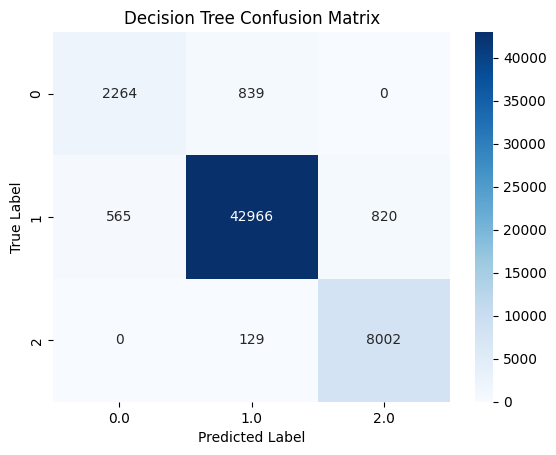

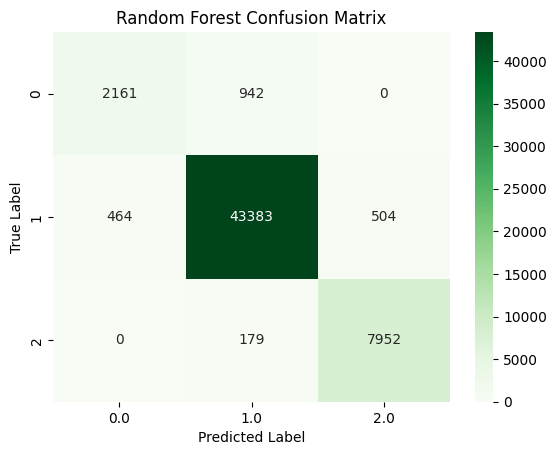

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# obtain classification results
confusion_matrix_dt = dt_predictions.groupBy("nd_category", "prediction").count().toPandas()
confusion_matrix_rf = rf_predictions.groupBy("nd_category", "prediction").count().toPandas()

# convert matrix to intergal
matrix_dt = confusion_matrix_dt.pivot(index="nd_category", columns="prediction", values="count").fillna(0).astype(int)

# plot heatmap
sns.heatmap(matrix_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# convert matrix to intergal
matrix_rf = confusion_matrix_rf.pivot(index="nd_category", columns="prediction", values="count").fillna(0).astype(int)

# plot heatmap
sns.heatmap(matrix_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# decision tree features importance
dt_importances = dt_model.featureImportances
print(f"Decision Tree Feature Importances: {dt_importances}")

Decision Tree Feature Importances: (3,[0,1,2],[0.9779244182921627,0.001689181807937225,0.02038639989990008])


In [ ]:
# random forest features importance
rf_importances = rf_model.featureImportances
print(f"Random Forest Feature Importances: {rf_importances}")

Random Forest Feature Importances: (3,[0,1,2],[0.9638955726605942,0.010115633518620354,0.025988793820785408])


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="nd_category", predictionCol="prediction")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="nd_category", predictionCol="prediction")

# Define the hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .addGrid(dt.minInfoGain, [0.0, 0.01, 0.05]) \
    .build()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="nd_category",
    predictionCol="prediction",
    metricName="accuracy"  # You can also use "f1"
)

In [ ]:
from pyspark.ml.tuning import CrossValidator

# Initialize CrossValidator
cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=4
)

In [ ]:
# Train the model using cross-validation
cvModel = cv.fit(train_data)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

In [ ]:
# Make predictions on the test dataset
best_predictions = bestModel.transform(test_data)

# Evaluate the accuracy of the best model
accuracy = evaluator.evaluate(best_predictions)
print(f"Best Model Accuracy: {accuracy}")

# Display the best hyperparameters
print(f"Best maxDepth: {bestModel.getMaxDepth()}")
print(f"Best maxBins: {bestModel.getMaxBins()}")
print(f"Best minInstancesPerNode: {bestModel.getMinInstancesPerNode()}")
print(f"Best minInfoGain: {bestModel.getMinInfoGain()}")

Best Model Accuracy: 0.9668075919762525
Best maxDepth: 15
Best maxBins: 64
Best minInstancesPerNode: 1
Best minInfoGain: 0.0
